#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|2|6|
|42|FM001|Agricultural products|Grocery|2|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/kt_aivle_proj/2024.11.13_proj6/'

In [3]:
import shutil
shutil.copy(f'{path}/train.zip', '/content/train.zip')
shutil.copy(f'{path}/test.zip', '/content/test.zip')

'/content/test.zip'

In [4]:
import zipfile
import os
# 폴더 생성
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/data/train', exist_ok=True)
os.makedirs('/content/data/test', exist_ok=True)

In [5]:
# 필요한 폴더 생성
os.makedirs('/content/data/train', exist_ok=True)
os.makedirs('/content/data/test', exist_ok=True)

# train.zip 파일 압축 해제
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    file_list = zip_ref.namelist()

    for f in file_list:
        if not f.endswith('/') and f.lower().endswith('.jpg'):
            file_name = os.path.basename(f)

            if not file_name.startswith('._'):
                d_path = os.path.join('/content/data/train', file_name)

                with zip_ref.open(f) as source, open(d_path, 'wb') as target:
                    target.write(source.read())

# test.zip 파일 압축 해제
with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
    file_list = zip_ref.namelist()

    for f in file_list:
        if not f.endswith('/') and f.lower().endswith('.jpg'):
            file_name = os.path.basename(f)

            if not file_name.startswith('._'):
                d_path = os.path.join('/content/data/test', file_name)

                with zip_ref.open(f) as source, open(d_path, 'wb') as target:
                    target.write(source.read())


### **(2) 라이브러리 설치 및 불러오기**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [5]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [29]:
display(oil_price.head(3))
display(orders.head(3))
display(sales.head(3))
display(products.head(3))
display(stores.head(3))

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66


,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875


,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7


,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4


In [7]:
df = pd.merge(sales, orders, on=['Date', 'Store_ID'], how='left')
df = pd.merge(df, oil_price, on='Date', how='left')
df = pd.merge(df, products, on='Product_ID', how='left')
df = pd.merge(df, stores, on='Store_ID', how='left')

#### 2) 기본 정보 조회

In [19]:
df.head(3)

,Date,Store_ID,Qty,Product_ID,CustomerCount,WTI_Price,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-01,1,0.0,3,NaN,NaN,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4
1,2014-01-01,1,0.0,5,NaN,NaN,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4
2,2014-01-01,1,0.0,7,NaN,NaN,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4


In [20]:
df.tail(3)

,Date,Store_ID,Qty,Product_ID,CustomerCount,WTI_Price,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
934272,2017-02-28,54,12.0,27,729.0,54.0,HH001,Home Appliances,Household Goods,2,150,LA,\tCalifornia,3
934273,2017-02-28,54,59.0,29,729.0,54.0,FP001,Prepared,Food,2,18,LA,\tCalifornia,3
934274,2017-02-28,54,4.0,32,729.0,54.0,GS001,Seafood,Grocery,3,34,LA,\tCalifornia,3


In [22]:
df.describe()

,Date,Store_ID,Qty,Product_ID,CustomerCount,WTI_Price,LeadTime,Price,Store_Type
count,934275,934275.000000,934275.000000,934275.000000,864516.000000,644745.000000,934275.000000,934275.000000,934275.000000
mean,2015-07-31 14:51:55.703620352,27.520398,654.136862,17.164075,1696.369267,61.279082,2.133168,27.838398,2.997527
min,2014-01-01 00:00:00,1.000000,0.000000,3.000000,5.000000,26.190000,2.000000,4.000000,1.000000
25%,2014-10-16 00:00:00,14.000000,10.000000,8.000000,1039.000000,44.940000,2.000000,6.000000,2.000000
50%,2015-08-01 00:00:00,28.000000,88.000000,15.000000,1391.000000,50.720000,2.000000,17.000000,3.000000
75%,2016-05-15 12:00:00,41.000000,562.000000,27.000000,2075.000000,82.810000,2.000000,34.000000,4.000000
max,2017-02-28 00:00:00,54.000000,124717.000000,42.000000,8359.000000,107.950000,3.000000,150.000000,5.000000
std,NaN,15.586942,1495.231047,10.370486,975.642343,23.788101,0.339757,35.312224,1.203162


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           934275 non-null  datetime64[ns]
 1   Store_ID       934275 non-null  int64         
 2   Qty            934275 non-null  float64       
 3   Product_ID     934275 non-null  int64         
 4   CustomerCount  864516 non-null  float64       
 5   WTI_Price      644745 non-null  float64       
 6   Product_Code   934275 non-null  object        
 7   SubCategory    934275 non-null  object        
 8   Category       934275 non-null  object        
 9   LeadTime       934275 non-null  int64         
 10  Price          934275 non-null  int64         
 11  City           934275 non-null  object        
 12  State          934275 non-null  object        
 13  Store_Type     934275 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(5

In [26]:
df.isna().sum()

,0
Date,0
Store_ID,0
Qty,0
Product_ID,0
CustomerCount,69759
WTI_Price,289530
Product_Code,0
SubCategory,0
Category,0
LeadTime,0


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발유 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
import matplotlib.pyplot as plt

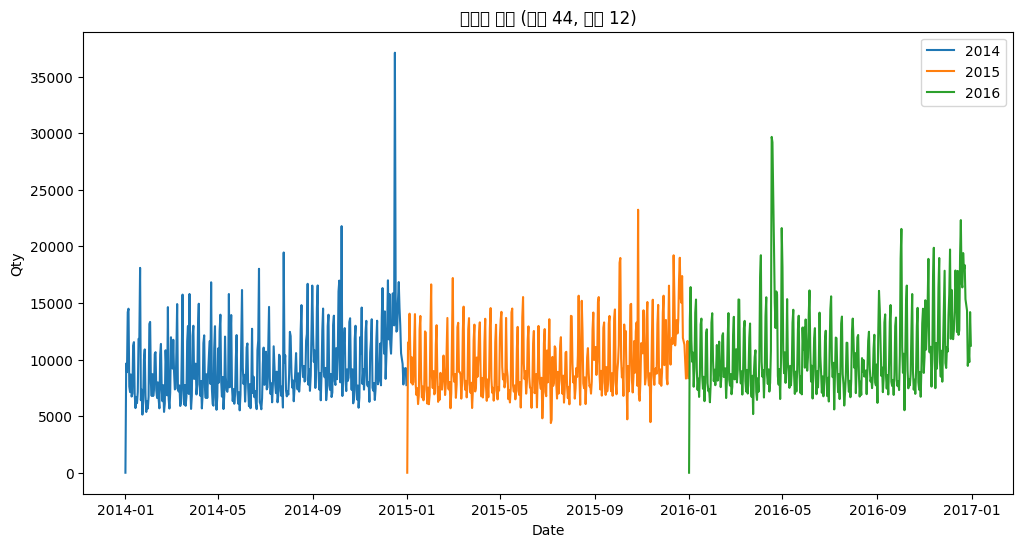

In [20]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = sales[(sales['Store_ID'] == store_id) & (sales['Product_ID'] == product_id)]

# Date 열을 datetime 형식으로 변환하고 연도를 새로운 열로 추가
filtered_sales['Date'] = pd.to_datetime(filtered_sales['Date'])
filtered_sales['Year'] = filtered_sales['Date'].dt.year

# 연도별로 판매량 데이터 필터링
years = [2014, 2015, 2016]
plt.figure(figsize=(12, 6))

for year in years:
    yearly_sales = filtered_sales[filtered_sales['Year'] == year]
    # 날짜별로 판매량을 집계
    yearly_sales_grouped = yearly_sales.groupby('Date')['Qty'].sum()
    # 연도별로 그래프 그리기
    plt.plot(yearly_sales_grouped.index, yearly_sales_grouped.values, label=f'{year}')

# 그래프 타이틀 및 축 설정
plt.title('판매량 추이 (매장 44, 상품 12)')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

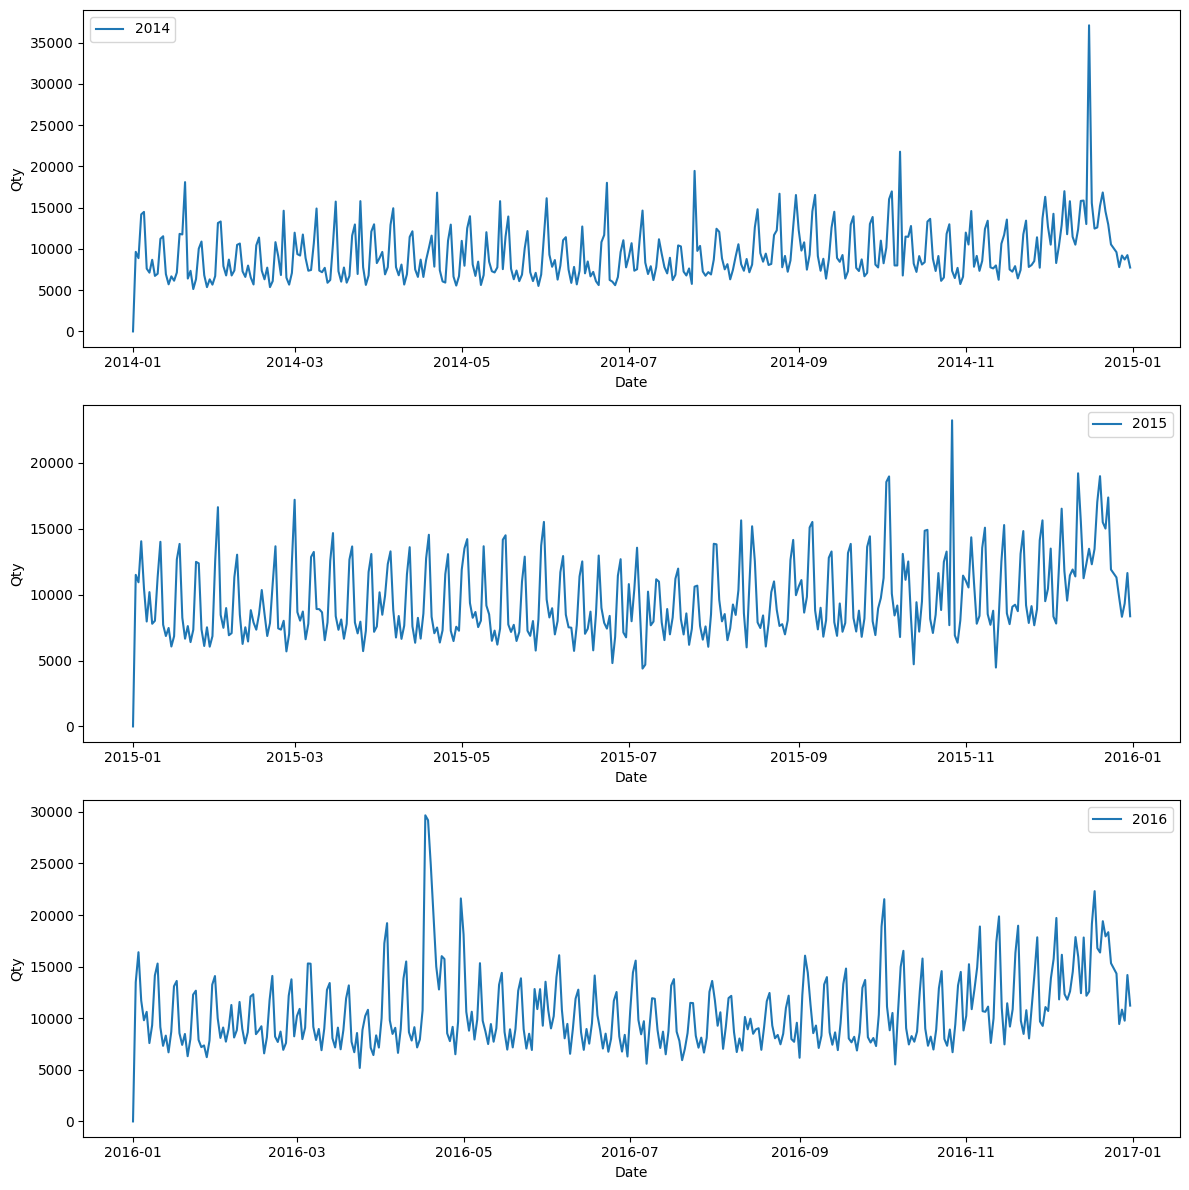

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = sales[(sales['Store_ID'] == store_id) & (sales['Product_ID'] == product_id)]

# Date 열을 datetime 형식으로 변환하고 연도를 새로운 열로 추가
filtered_sales['Date'] = pd.to_datetime(filtered_sales['Date'])
filtered_sales['Year'] = filtered_sales['Date'].dt.year

# 연도별로 데이터 필터링 및 시각화
years = [2014, 2015, 2016]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

for i, year in enumerate(years):
    yearly_sales = filtered_sales[filtered_sales['Year'] == year]
    yearly_sales_grouped = yearly_sales.groupby('Date')['Qty'].sum()

    # 각 연도에 대해 subplot에 그래프 추가
    axes[i].plot(yearly_sales_grouped.index, yearly_sales_grouped.values, label=f'{year}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Qty')
    axes[i].legend()

plt.tight_layout()
plt.show()

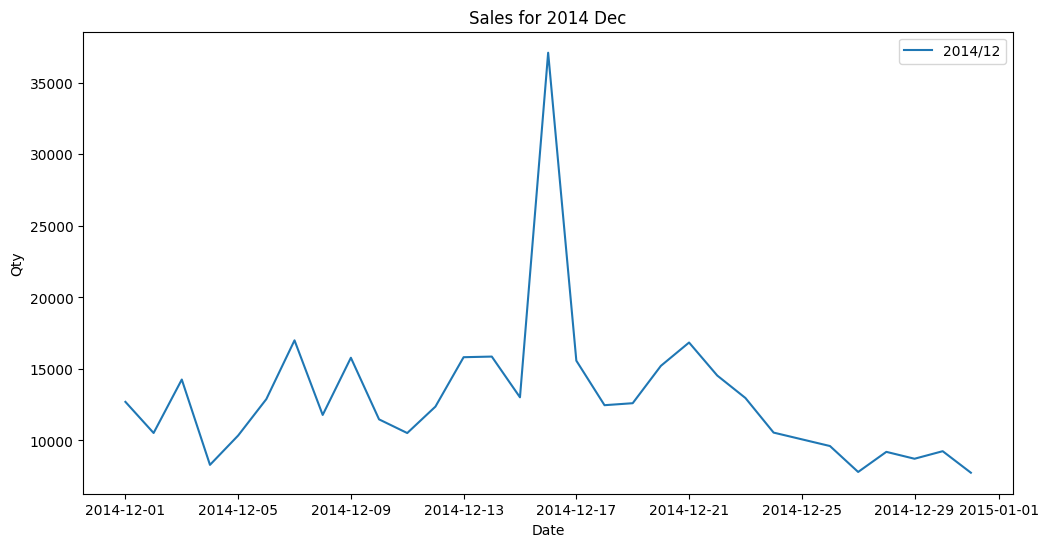

<Figure size 600x300 with 0 Axes>

In [51]:
# 2014
# Date 열을 datetime 형식으로 변환하고 연도를 새로운 열로 추가
filtered_sales['Month'] = filtered_sales['Date'].dt.month

# 2014년 11월과 12월만 필터링
filtered_sales_2014 = filtered_sales[(filtered_sales['Year'] == 2014) & (filtered_sales['Month'].isin([12]))]

# 연도별로 데이터 필터링 및 시각화
fig, ax = plt.subplots(figsize=(12, 6))

yearly_sales_grouped = filtered_sales_2014.groupby('Date')['Qty'].sum()

# 그래프 추가
plt.figure(figsize=(6,3))
ax.plot(yearly_sales_grouped.index, yearly_sales_grouped.values, label='2014/12')
ax.set_xlabel('Date')
ax.set_ylabel('Qty')
ax.set_title('Sales for 2014 Dec')
ax.legend()

plt.tight_layout()
plt.show()


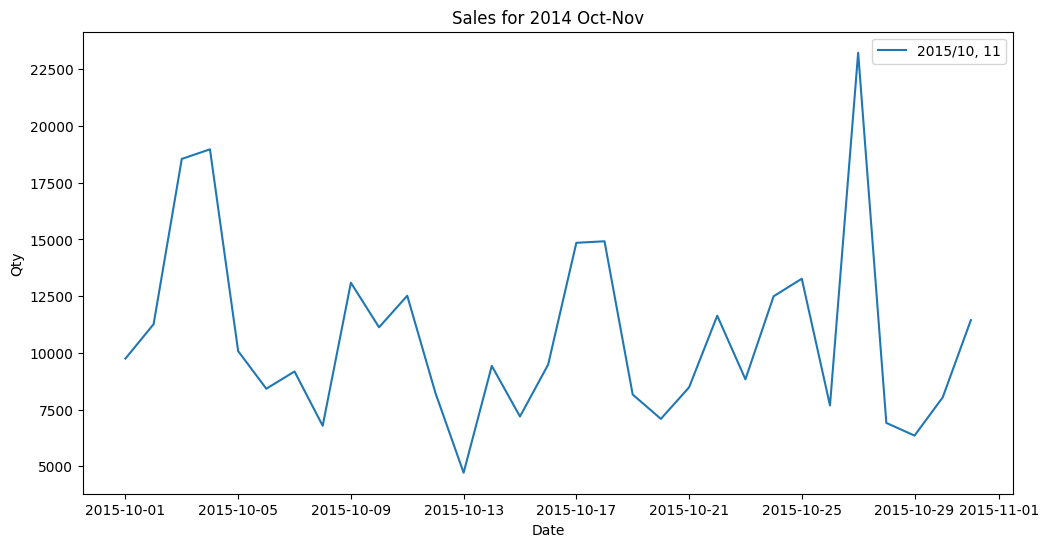

<Figure size 600x300 with 0 Axes>

In [60]:
# 2015
filtered_sales['Month'] = filtered_sales['Date'].dt.month

# 2014년 11월과 12월만 필터링
filtered_sales_2014 = filtered_sales[(filtered_sales['Year'] == 2015) & (filtered_sales['Month'].isin([10]))]

# 연도별로 데이터 필터링 및 시각화
fig, ax = plt.subplots(figsize=(12, 6))

yearly_sales_grouped = filtered_sales_2014.groupby('Date')['Qty'].sum()

# 그래프 추가
plt.figure(figsize=(6,3))
ax.plot(yearly_sales_grouped.index, yearly_sales_grouped.values, label='2015/10, 11')
ax.set_xlabel('Date')
ax.set_ylabel('Qty')
ax.set_title('Sales for 2014 Oct-Nov')
ax.legend()

plt.tight_layout()
plt.show()


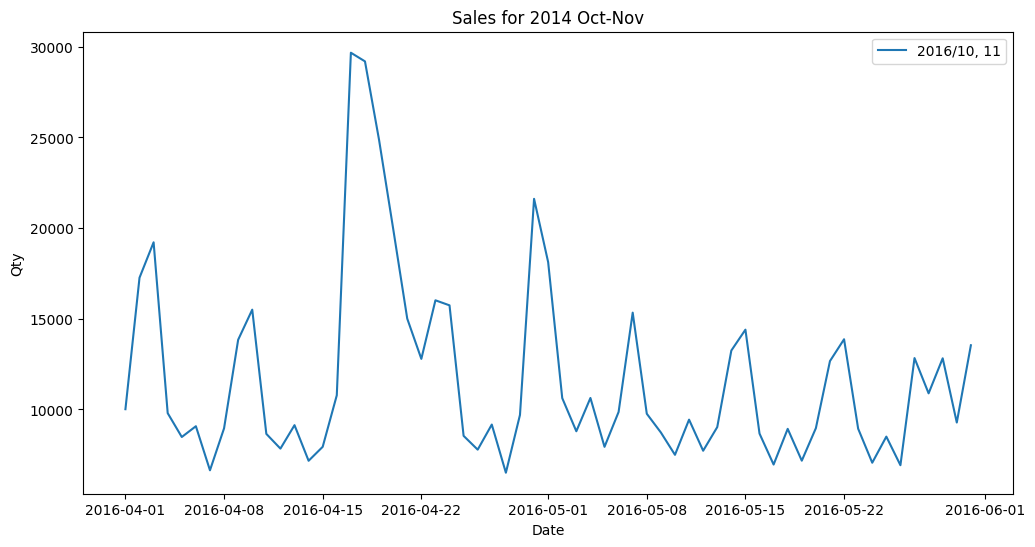

<Figure size 600x300 with 0 Axes>

In [62]:
# 2016
# Date 열을 datetime 형식으로 변환하고 연도를 새로운 열로 추가
filtered_sales['Month'] = filtered_sales['Date'].dt.month

# 2014년 11월과 12월만 필터링
filtered_sales_2014 = filtered_sales[(filtered_sales['Year'] == 2016) & (filtered_sales['Month'].isin([4,5]))]

# 연도별로 데이터 필터링 및 시각화
fig, ax = plt.subplots(figsize=(12, 6))

yearly_sales_grouped = filtered_sales_2014.groupby('Date')['Qty'].sum()

# 그래프 추가
plt.figure(figsize=(6,3))
ax.plot(yearly_sales_grouped.index, yearly_sales_grouped.values, label='2016/10, 11')
ax.set_xlabel('Date')
ax.set_ylabel('Qty')
ax.set_title('Sales for 2014 Oct-Nov')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 2014년 12월 14-18일 급증
# 2015년 10월 2-4일, 25-28일 급증
# 2016년 4월 급증

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [25]:
df['Category'].value_counts()

,count
Category,
Food,311040
Household Goods,311040
Grocery,187779
Drink,124416


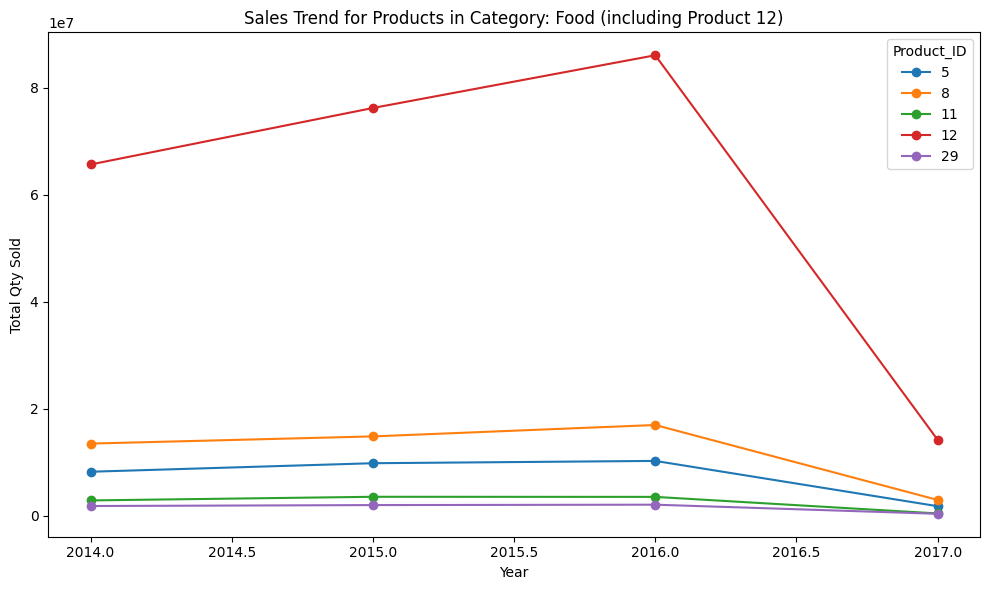

In [65]:
# 대상 상품의 카테고리 정보 추출
target_product_id = 12
target_category = df[df['Product_ID'] == target_product_id]['Category'].iloc[0]

# 동일 카테고리 내 모든 상품들의 판매량 집계
category_sales = df[df['Category'] == target_category]

# Date 열을 datetime 형식으로 변환
category_sales['Date'] = pd.to_datetime(category_sales['Date'])

# 카테고리별 연도별 판매량 합산
category_sales['Year'] = category_sales['Date'].dt.year
category_sales_grouped = category_sales.groupby(['Year', 'Product_ID'])['Qty'].sum().unstack()

# 12번 상품의 판매량 추이와 다른 상품들의 판매량을 시각화
fig, ax = plt.subplots(figsize=(10, 6))
category_sales_grouped.plot(ax=ax, marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Total Qty Sold')
ax.set_title(f'Sales Trend for Products in Category: {target_category} (including Product {target_product_id})')
plt.legend(title="Product_ID")
plt.tight_layout()
plt.show()

In [ ]:
# 12번 상품: food
# food인 상품- 5, 8, 11, 12, 29
# 왜 12번 상품만 판매량이 많은가? (3-4배 차이) 핵심상품인가?

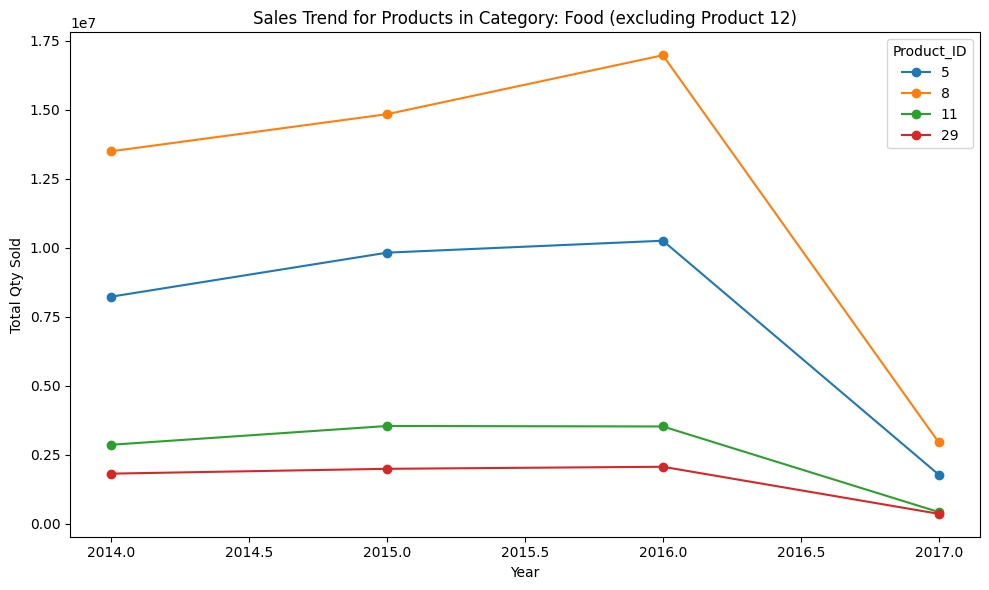

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# 대상 상품의 카테고리 정보 추출
target_product_id = 12
target_category = df[df['Product_ID'] == target_product_id]['Category'].iloc[0]

# 동일 카테고리 내 모든 상품들의 판매량 집계
category_sales = df[df['Category'] == target_category]

# Date 열을 datetime 형식으로 변환
category_sales['Date'] = pd.to_datetime(category_sales['Date'])

# 카테고리별 연도별 판매량 합산
category_sales['Year'] = category_sales['Date'].dt.year
category_sales_grouped = category_sales.groupby(['Year', 'Product_ID'])['Qty'].sum().unstack()

# 12번 상품을 제외한 판매량 데이터만 선택
category_sales_grouped_excluding_12 = category_sales_grouped.drop(target_product_id, axis=1)

# 12번 상품을 제외한 판매량 추이 시각화
fig, ax = plt.subplots(figsize=(10, 6))
category_sales_grouped_excluding_12.plot(ax=ax, marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Total Qty Sold')
ax.set_title(f'Sales Trend for Products in Category: {target_category} (excluding Product {target_product_id})')
plt.legend(title="Product_ID")
plt.tight_layout()
plt.show()

### 3) 휘발유 가격과 상품 판매량 추이 비교

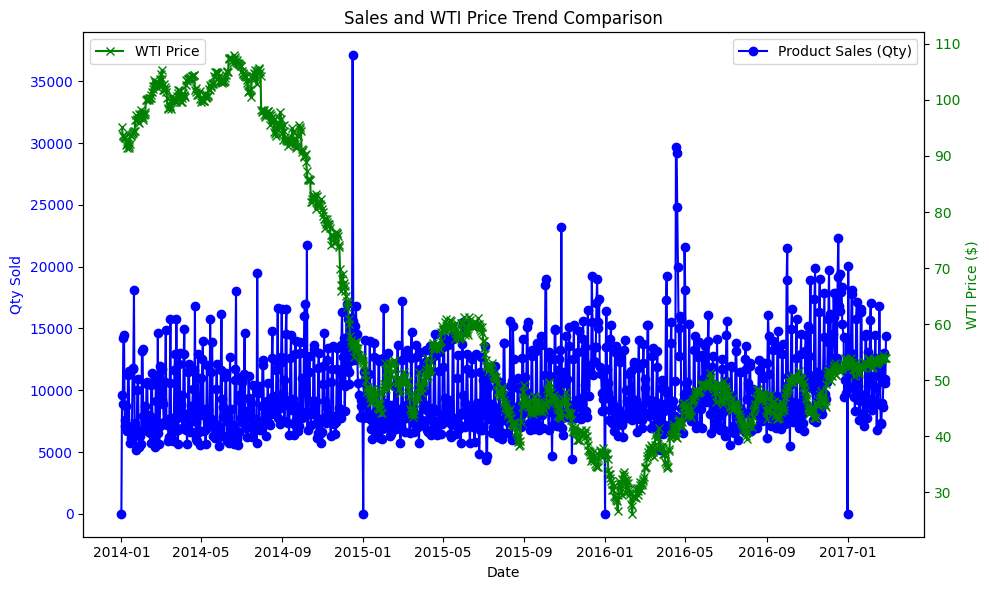

In [24]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 연도별 판매량 합산
filtered_sales['Year'] = filtered_sales['Date'].dt.year
yearly_sales = filtered_sales.groupby(['Year', 'Date'])['Qty'].sum()

# 'Date'를 하나의 단일 열로 설정하여 플로팅
yearly_sales = yearly_sales.reset_index()  # 'Year'와 'Date'를 모두 열로 변경
yearly_sales['Date'] = pd.to_datetime(yearly_sales['Date'])  # Date 형식으로 변환

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (연도별 합산)
ax1.plot(yearly_sales['Date'], yearly_sales['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

# 휘발유 가격 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales['Date'], filtered_sales['WTI_Price'], color='green', label='WTI Price', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

# 제목 및 레이아웃 설정
plt.title('Sales and WTI Price Trend Comparison')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()

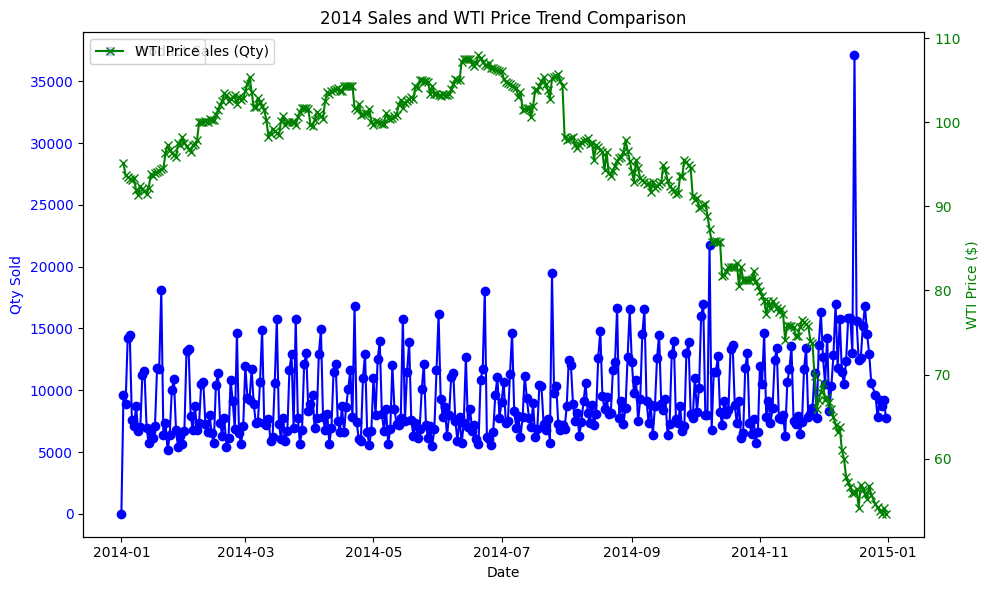

In [25]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 2014년만 필터링
filtered_sales_2014 = filtered_sales[filtered_sales['Date'].dt.year == 2014]

# 연도별 판매량 합산
filtered_sales_2014['Year'] = filtered_sales_2014['Date'].dt.year
yearly_sales_2014 = filtered_sales_2014.groupby(['Year', 'Date'])['Qty'].sum()

# 'Date'를 하나의 단일 열로 설정하여 플로팅
yearly_sales_2014 = yearly_sales_2014.reset_index()  # 'Year'와 'Date'를 모두 열로 변경
yearly_sales_2014['Date'] = pd.to_datetime(yearly_sales_2014['Date'])  # Date 형식으로 변환

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2014년만)
ax1.plot(yearly_sales_2014['Date'], yearly_sales_2014['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

# 휘발유 가격 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales_2014['Date'], filtered_sales_2014['WTI_Price'], color='green', label='WTI Price', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

# 제목 및 레이아웃 설정
plt.title('2014 Sales and WTI Price Trend Comparison')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


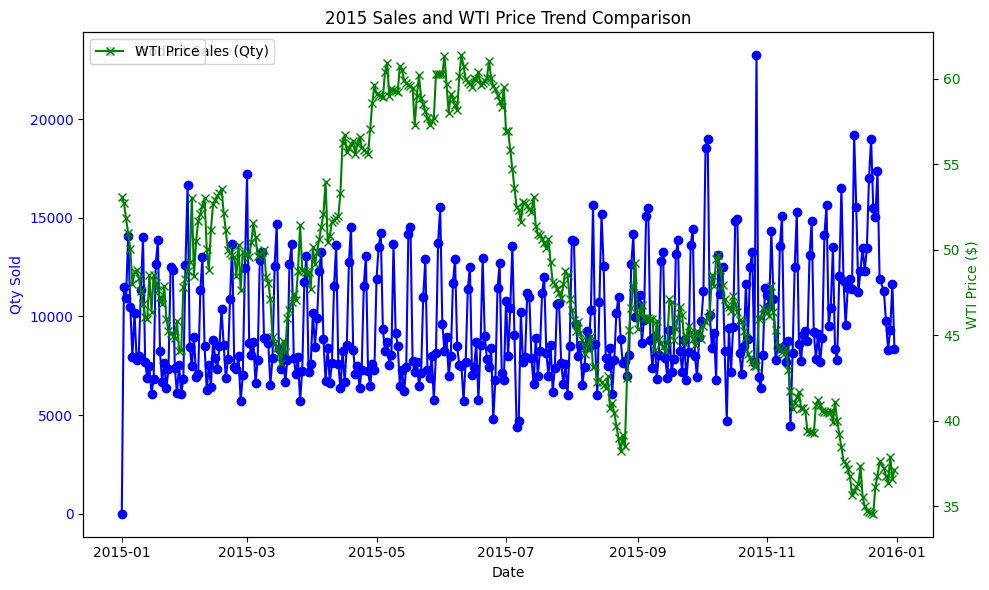

In [26]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 2015년만 필터링
filtered_sales_2015 = filtered_sales[filtered_sales['Date'].dt.year == 2015]

# 연도별 판매량 합산
filtered_sales_2015['Year'] = filtered_sales_2015['Date'].dt.year
yearly_sales_2015 = filtered_sales_2015.groupby(['Year', 'Date'])['Qty'].sum()

# 'Date'를 하나의 단일 열로 설정하여 플로팅
yearly_sales_2015 = yearly_sales_2015.reset_index()  # 'Year'와 'Date'를 모두 열로 변경
yearly_sales_2015['Date'] = pd.to_datetime(yearly_sales_2015['Date'])  # Date 형식으로 변환

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2015년만)
ax1.plot(yearly_sales_2015['Date'], yearly_sales_2015['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

# 휘발유 가격 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales_2015['Date'], filtered_sales_2015['WTI_Price'], color='green', label='WTI Price', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

# 제목 및 레이아웃 설정
plt.title('2015 Sales and WTI Price Trend Comparison')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


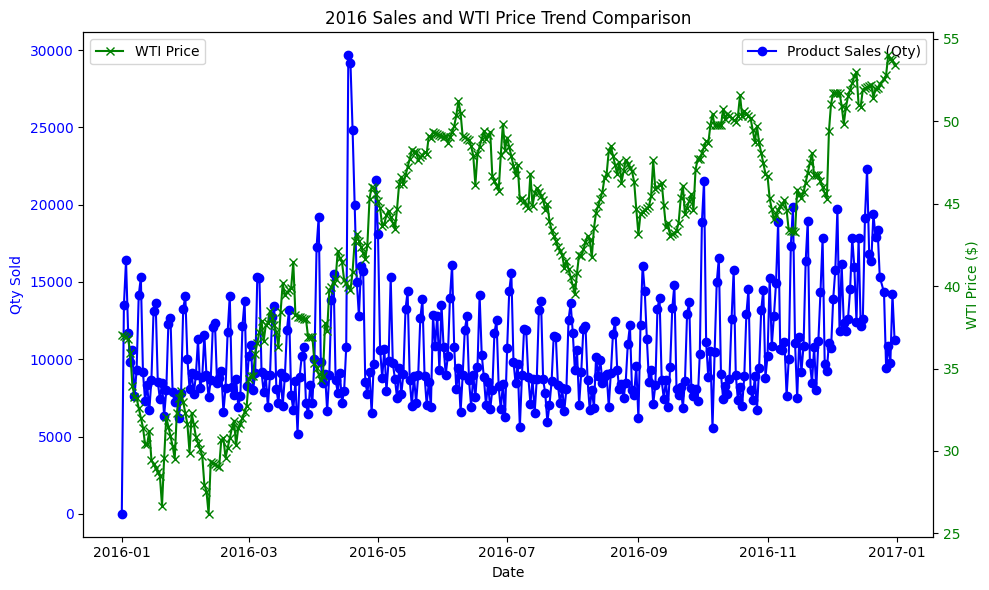

In [29]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 2016년만 필터링
filtered_sales_2016 = filtered_sales[filtered_sales['Date'].dt.year == 2016]

# 연도별 판매량 합산
filtered_sales_2016['Year'] = filtered_sales_2016['Date'].dt.year
yearly_sales_2016 = filtered_sales_2016.groupby(['Year', 'Date'])['Qty'].sum()

# 'Date'를 하나의 단일 열로 설정하여 플로팅
yearly_sales_2016 = yearly_sales_2016.reset_index()  # 'Year'와 'Date'를 모두 열로 변경
yearly_sales_2016['Date'] = pd.to_datetime(yearly_sales_2016['Date'])  # Date 형식으로 변환

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2016년만)
ax1.plot(yearly_sales_2016['Date'], yearly_sales_2016['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

# 휘발유 가격 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales_2016['Date'], filtered_sales_2016['WTI_Price'], color='green', label='WTI Price', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()

# 제목 및 레이아웃 설정
plt.title('2016 Sales and WTI Price Trend Comparison')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


### 4) 방문 고객수와 상품 판매량 추이 비교

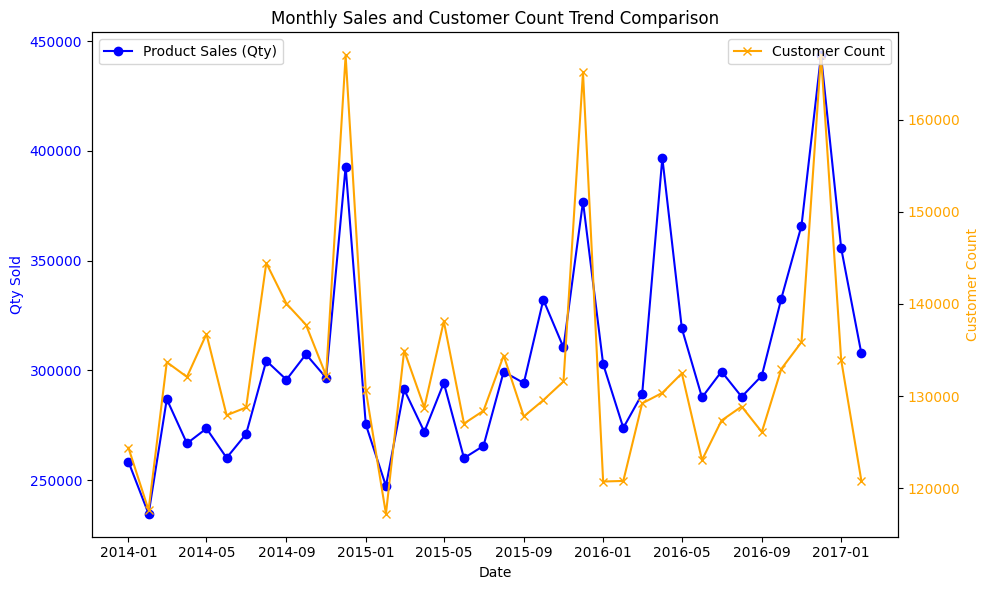

In [30]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 연도별 판매량 합산
filtered_sales['Year'] = filtered_sales['Date'].dt.year
filtered_sales['Month'] = filtered_sales['Date'].dt.to_period('M')  # 월별 집계
monthly_sales = filtered_sales.groupby('Month').agg({'Qty': 'sum', 'CustomerCount': 'sum'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (월별)
ax1.plot(monthly_sales['Month'].dt.to_timestamp(), monthly_sales['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 방문 고객수 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(monthly_sales['Month'].dt.to_timestamp(), monthly_sales['CustomerCount'], color='orange', label='Customer Count', marker='x')
ax2.set_ylabel('Customer Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('Monthly Sales and Customer Count Trend Comparison')
fig.tight_layout()
plt.show()


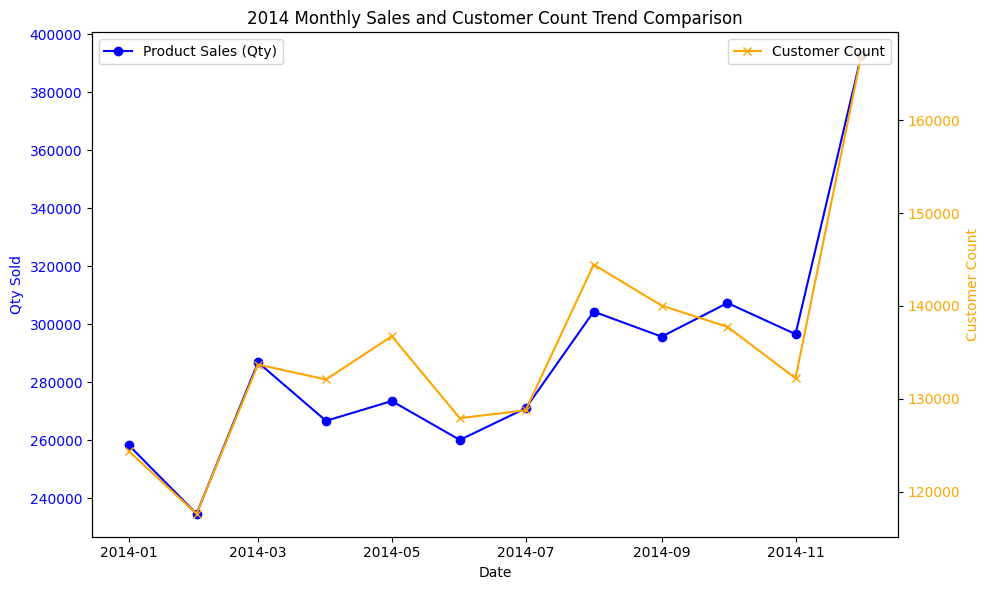

In [31]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 2014년만 필터링
filtered_sales_2014 = filtered_sales[filtered_sales['Date'].dt.year == 2014]

# 연도별 판매량 합산
filtered_sales_2014['Year'] = filtered_sales_2014['Date'].dt.year
filtered_sales_2014['Month'] = filtered_sales_2014['Date'].dt.to_period('M')  # 월별 집계
monthly_sales_2014 = filtered_sales_2014.groupby('Month').agg({'Qty': 'sum', 'CustomerCount': 'sum'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2014년만)
ax1.plot(monthly_sales_2014['Month'].dt.to_timestamp(), monthly_sales_2014['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 방문 고객수 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(monthly_sales_2014['Month'].dt.to_timestamp(), monthly_sales_2014['CustomerCount'], color='orange', label='Customer Count', marker='x')
ax2.set_ylabel('Customer Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('2014 Monthly Sales and Customer Count Trend Comparison')
fig.tight_layout()
plt.show()


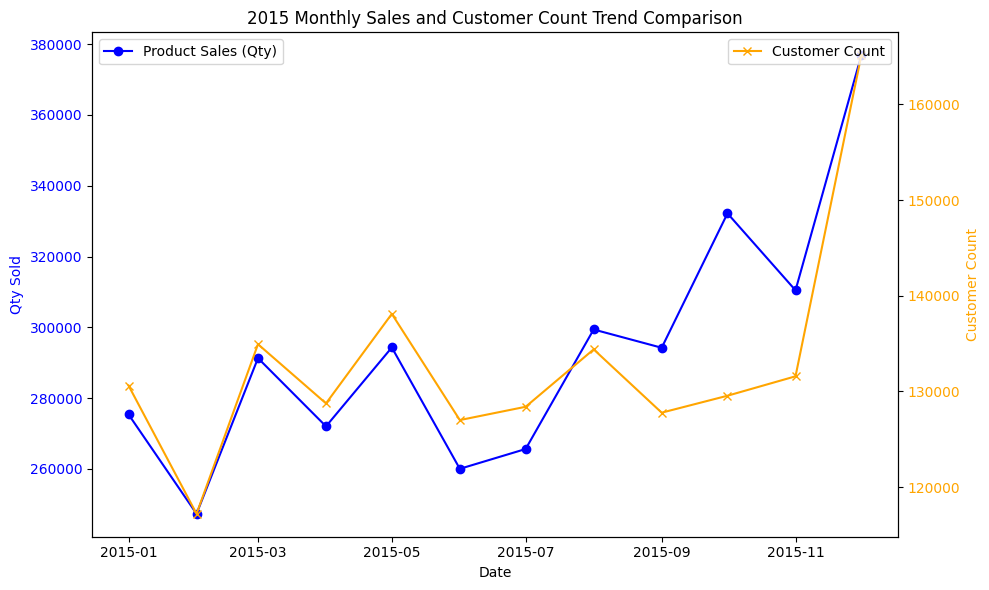

In [32]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 2015년만 필터링
filtered_sales_2015 = filtered_sales[filtered_sales['Date'].dt.year == 2015]

# 연도별 판매량 합산
filtered_sales_2015['Year'] = filtered_sales_2015['Date'].dt.year
filtered_sales_2015['Month'] = filtered_sales_2015['Date'].dt.to_period('M')  # 월별 집계
monthly_sales_2015 = filtered_sales_2015.groupby('Month').agg({'Qty': 'sum', 'CustomerCount': 'sum'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2015년만)
ax1.plot(monthly_sales_2015['Month'].dt.to_timestamp(), monthly_sales_2015['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 방문 고객수 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(monthly_sales_2015['Month'].dt.to_timestamp(), monthly_sales_2015['CustomerCount'], color='orange', label='Customer Count', marker='x')
ax2.set_ylabel('Customer Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('2015 Monthly Sales and Customer Count Trend Comparison')
fig.tight_layout()
plt.show()


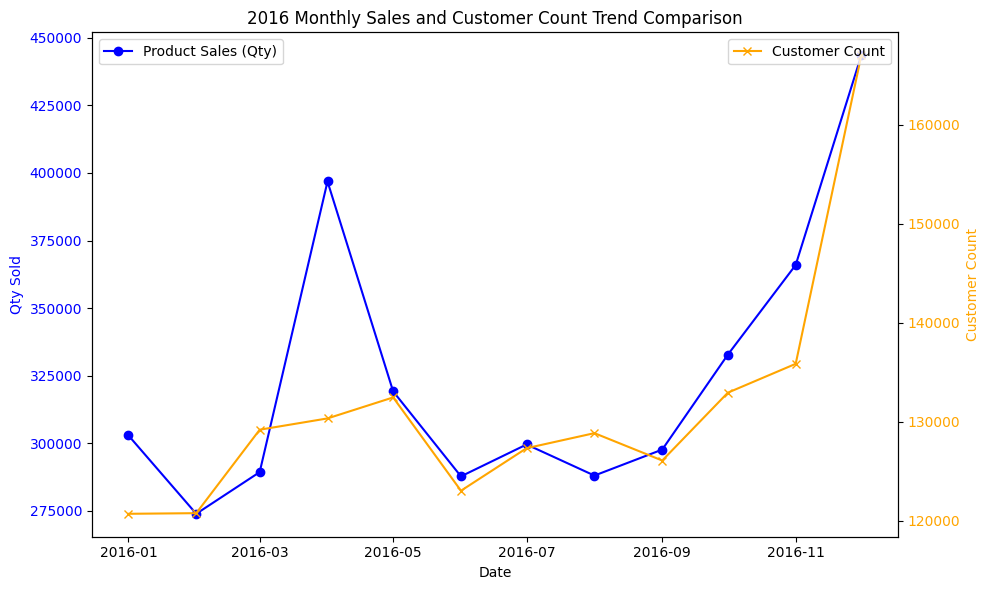

In [33]:
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 2016년만 필터링
filtered_sales_2016 = filtered_sales[filtered_sales['Date'].dt.year == 2016]

# 연도별 판매량 합산
filtered_sales_2016['Year'] = filtered_sales_2016['Date'].dt.year
filtered_sales_2016['Month'] = filtered_sales_2016['Date'].dt.to_period('M')  # 월별 집계
monthly_sales_2016 = filtered_sales_2016.groupby('Month').agg({'Qty': 'sum', 'CustomerCount': 'sum'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매량 추이 그래프 (2016년만)
ax1.plot(monthly_sales_2016['Month'].dt.to_timestamp(), monthly_sales_2016['Qty'], color='blue', label='Product Sales (Qty)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 방문 고객수 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(monthly_sales_2016['Month'].dt.to_timestamp(), monthly_sales_2016['CustomerCount'], color='orange', label='Customer Count', marker='x')
ax2.set_ylabel('Customer Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('2016 Monthly Sales and Customer Count Trend Comparison')
fig.tight_layout()
plt.show()


In [ ]:
# 대체로 방문 고객수와 상품 판매량은 비슷함
# 다만 2016년 3-5월에 판매량이 월등하게 높음

In [ ]:
## 종합
# 상품별 판매량 차이 ㅇ
# 휘발유와 관계 x
# 방문고객과 상품 판매량은 상관 o

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

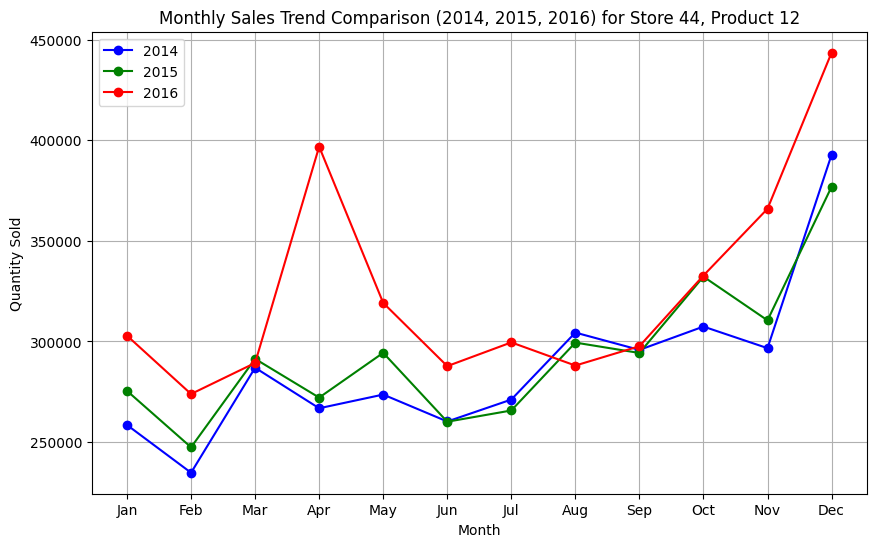

In [42]:
# 44번 매장의 12번 상품에 대해 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)]

# 2014년, 2015년, 2016년 데이터 필터링
filtered_sales_2014 = filtered_sales[filtered_sales['Date'].dt.year == 2014]
filtered_sales_2015 = filtered_sales[filtered_sales['Date'].dt.year == 2015]
filtered_sales_2016 = filtered_sales[filtered_sales['Date'].dt.year == 2016]

# 월별 판매량 합산
monthly_sales_2014 = filtered_sales_2014.groupby(filtered_sales_2014['Date'].dt.month).agg({'Qty': 'sum'}).reset_index()
monthly_sales_2015 = filtered_sales_2015.groupby(filtered_sales_2015['Date'].dt.month).agg({'Qty': 'sum'}).reset_index()
monthly_sales_2016 = filtered_sales_2016.groupby(filtered_sales_2016['Date'].dt.month).agg({'Qty': 'sum'}).reset_index()

# 시각화 (2014년, 2015년, 2016년 월별 판매량)
plt.figure(figsize=(10, 6))

# 각 연도에 대해 월별 판매량 그래프 추가
plt.plot(monthly_sales_2014['Date'], monthly_sales_2014['Qty'], marker='o', color='blue', label='2014')
plt.plot(monthly_sales_2015['Date'], monthly_sales_2015['Qty'], marker='o', color='green', label='2015')
plt.plot(monthly_sales_2016['Date'], monthly_sales_2016['Qty'], marker='o', color='red', label='2016')

# 제목, 레이블, 범례 설정
plt.title('Monthly Sales Trend Comparison (2014, 2015, 2016) for Store 44, Product 12')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(loc='upper left')
plt.grid(True)

# 시각화
plt.show()

In [ ]:
# 12번 상품의 2016년 3-5월 ?
# 2014, 2015년은 12월로 갈 수록 증가하는 추세

<Figure size 1200x800 with 0 Axes>

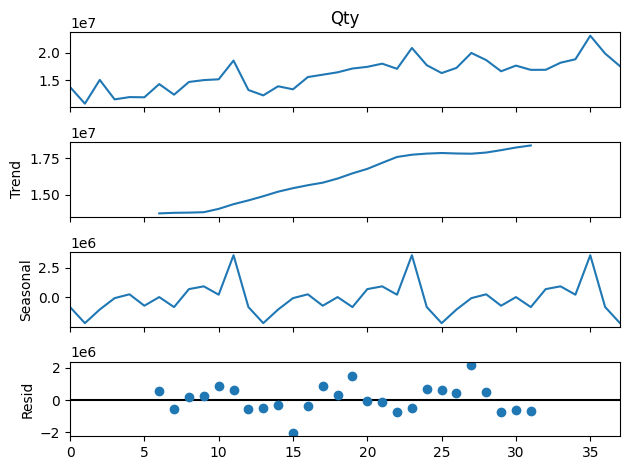

In [40]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 전체 데이터를 월별로 집계
monthly_sales = df.groupby(df['Date'].dt.to_period('M')).agg({'Qty': 'sum'}).reset_index()

# 월별로 시계열 데이터 설정
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()

# 시계열 분해
decomposition = seasonal_decompose(monthly_sales['Qty'], model='additive', period=12)

# 시계열 분해 결과 시각화
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()


In [ ]:
# 실제 데이터
# 판매량이 시간이 흐름에 따라 전반적으로 증가
# 12월로 갈 수록 증가하는 계절성이 보임
# 추세와 계절성을 제거한 후 남은 무작위 잡음. 0을 중심으로 흩어져 있어 특별한 패턴 x

### 2) 요일별 변화량 비교

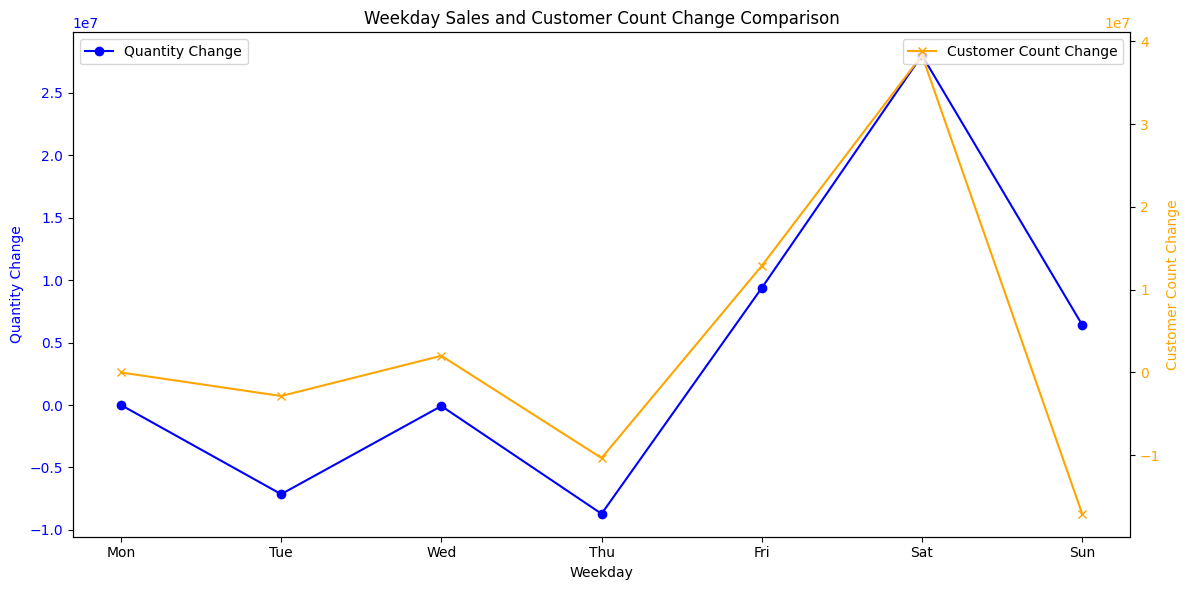

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# 'Date' 컬럼을 datetime 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 요일 정보 추출 (0=월요일, 6=일요일)
df['Weekday'] = df['Date'].dt.weekday

# 요일별 판매량 및 고객 수 합산
weekday_sales = df.groupby('Weekday').agg({'Qty': 'sum', 'CustomerCount': 'sum'}).reset_index()

# 요일별 판매량과 고객 수 변화량 계산 (주어진 요일의 값과 이전 요일의 차이)
weekday_sales['Qty_Change'] = weekday_sales['Qty'].diff().fillna(0)
weekday_sales['CustomerCount_Change'] = weekday_sales['CustomerCount'].diff().fillna(0)

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 판매량 변화량 그래프
ax1.plot(weekday_sales['Weekday'], weekday_sales['Qty_Change'], color='blue', marker='o', label='Quantity Change')
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Quantity Change', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(weekday_sales['Weekday'])
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.legend(loc='upper left')

# 고객 수 변화량 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(weekday_sales['Weekday'], weekday_sales['CustomerCount_Change'], color='orange', marker='x', label='Customer Count Change')
ax2.set_ylabel('Customer Count Change', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('Weekday Sales and Customer Count Change Comparison')
fig.tight_layout()
plt.show()


In [ ]:
# 월 -목: 평일은 실구매보다 아이쇼핑이 많음
# 금-일: 실구매가 더 많음
# 평일날 봐뒀다가 주말에 구매하는 건가?

### 3) 시계열 데이터 분해

In [44]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

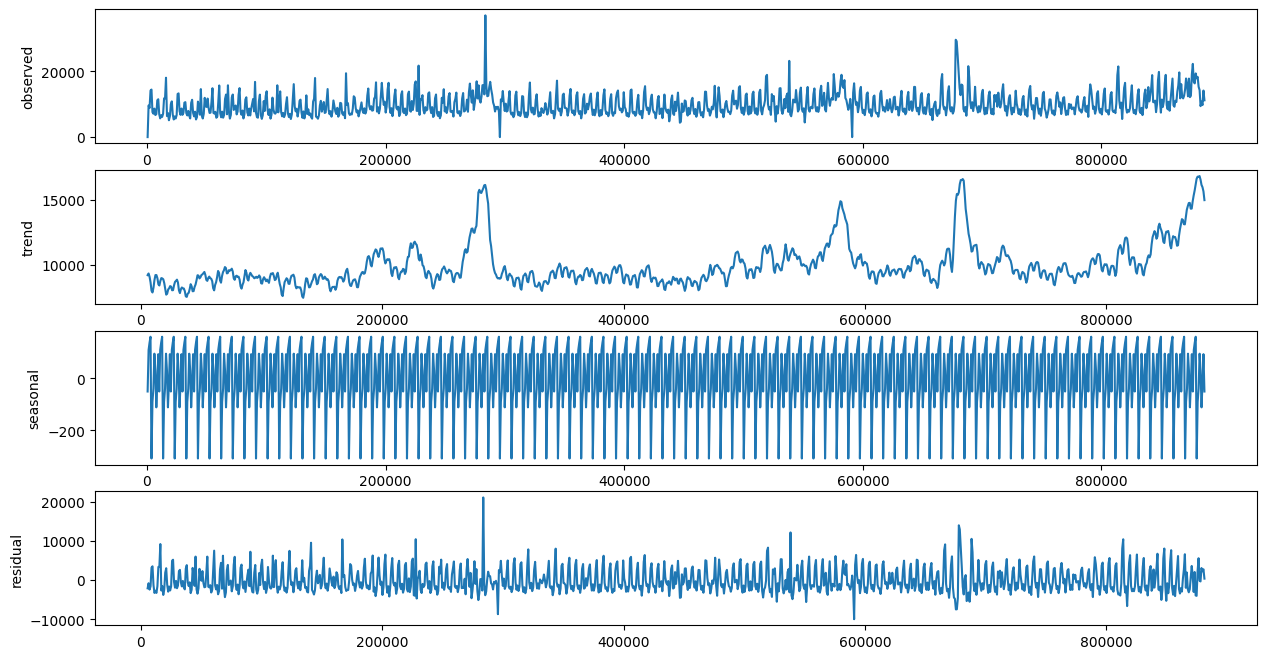

,observed,trend,seasonal,residual
651,0.0,NaN,-50.724806,NaN
1462,9647.0,NaN,108.423490,NaN
2273,8879.0,NaN,136.827694,NaN
3084,14188.0,NaN,159.339268,NaN
3895,14490.0,NaN,-307.764899,NaN
...,...,...,...,...
883022,9439.0,NaN,28.488342,NaN
883833,10835.0,NaN,-111.496380,NaN
884644,9766.0,NaN,-19.953554,NaN
885455,14190.0,NaN,92.527642,NaN


In [48]:
decomp_plot(12, '2014-01-01', '2016-12-31', 12)

In [ ]:
#1.관측: 일정한 변동과 때때로 급등하는 부분 o
#2. 추세: 단기 변동을 제거하고 시계열의 장기적인 진행 방향을 나타내는 구성 요소
# 시간에 따라 전반적으로 증가. 일부 구간에서 피크가 나타나 장기적인 성장 패턴이나 변화 가능성을 시사
#4. 잔차

### 4) 그 외 패턴 찾아보기

In [51]:
# 같은 지역
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           934275 non-null  datetime64[ns]
 1   Store_ID       934275 non-null  int64         
 2   Qty            934275 non-null  float64       
 3   Product_ID     934275 non-null  int64         
 4   CustomerCount  864516 non-null  float64       
 5   WTI_Price      644745 non-null  float64       
 6   Product_Code   934275 non-null  object        
 7   SubCategory    934275 non-null  object        
 8   Category       934275 non-null  object        
 9   LeadTime       934275 non-null  int64         
 10  Price          934275 non-null  int64         
 11  City           934275 non-null  object        
 12  State          934275 non-null  object        
 13  Store_Type     934275 non-null  int64         
 14  Weekday        934275 non-null  int32         
dtype

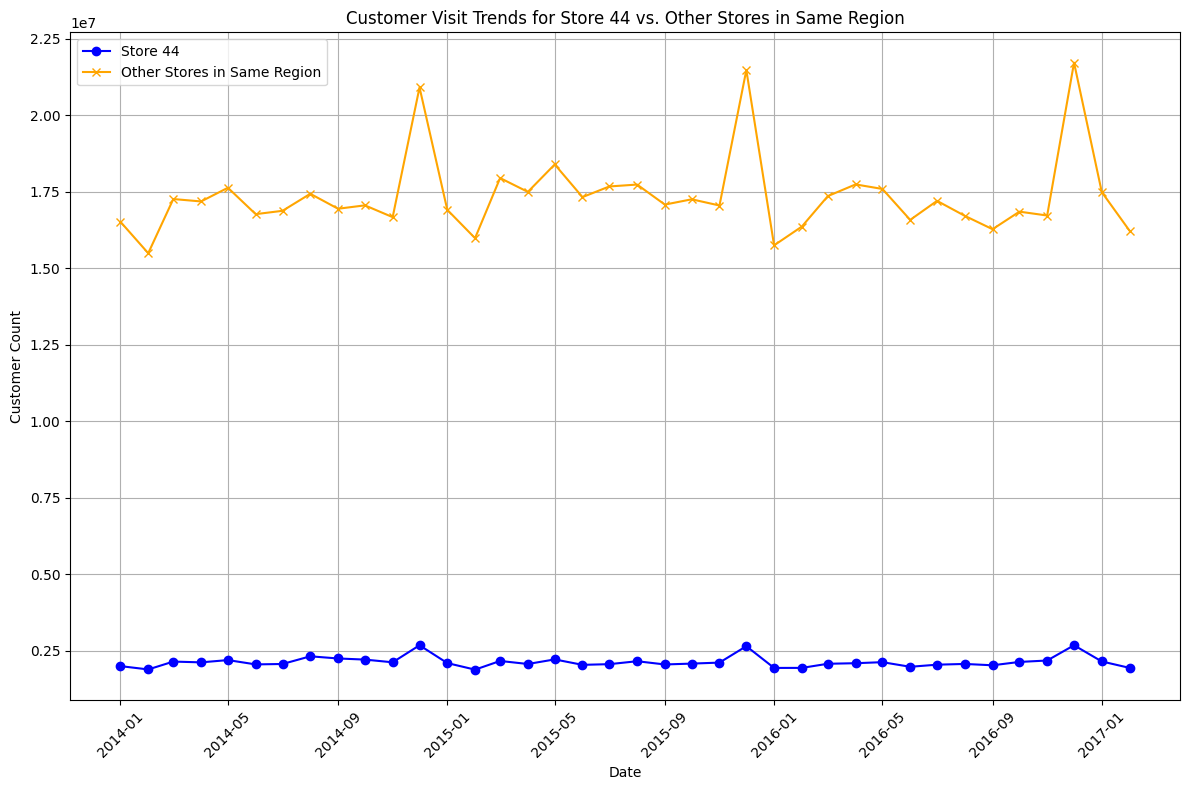

In [52]:
store_id_44 = 44
store_44 = df[(df['Store_ID'] == store_id_44)]

# 44번 매장과 동일한 지역 (City)에서 다른 매장들의 데이터를 가져옵니다.
same_region_stores = df[(df['City'] == store_44['City'].iloc[0]) & (df['Store_ID'] != store_id_44)]

# 44번 매장 월별 고객 방문 수
store_44_monthly = store_44.groupby(store_44['Date'].dt.to_period('M')).agg({'CustomerCount': 'sum'}).reset_index()

# 같은 지역 다른 매장들의 월별 고객 방문 수
same_region_monthly = same_region_stores.groupby(same_region_stores['Date'].dt.to_period('M')).agg({'CustomerCount': 'sum'}).reset_index()

# 시각화
plt.figure(figsize=(12, 8))

# 44번 매장 고객 방문 수 그래프
plt.plot(store_44_monthly['Date'].dt.to_timestamp(), store_44_monthly['CustomerCount'], label="Store 44", color='blue', marker='o')

# 같은 지역 다른 매장들의 고객 방문 수 그래프
plt.plot(same_region_monthly['Date'].dt.to_timestamp(), same_region_monthly['CustomerCount'], label="Other Stores in Same Region", color='orange', marker='x')

# 제목, 레이블 설정
plt.title('Customer Visit Trends for Store 44 vs. Other Stores in Same Region')
plt.xlabel('Date')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.legend()

# 그리드 추가
plt.grid(True)

# 시각화
plt.tight_layout()
plt.show()


In [53]:
# 44번 매장과 같은 지역 매장들의 월별 고객 방문수
store_44_monthly = store_44.groupby(store_44['Date'].dt.to_period('M')).agg({'CustomerCount': 'sum'}).reset_index()
same_region_monthly = same_region_stores.groupby(same_region_stores['Date'].dt.to_period('M')).agg({'CustomerCount': 'sum'}).reset_index()

# 인덱스를 동일하게 맞춰줍니다 (두 DataFrame의 날짜를 기준으로)
store_44_monthly['Date'] = store_44_monthly['Date'].dt.to_timestamp()
same_region_monthly['Date'] = same_region_monthly['Date'].dt.to_timestamp()

# 날짜를 기준으로 두 데이터프레임을 합쳐줍니다
merged_data = pd.merge(store_44_monthly, same_region_monthly, on='Date', suffixes=('_store_44', '_same_region'))

# Pearson 상관계수 계산
correlation = merged_data['CustomerCount_store_44'].corr(merged_data['CustomerCount_same_region'])

# 상관관계 출력
print(f"Correlation between Store 44 and other stores in the same region: {correlation:.4f}")

Correlation between Store 44 and other stores in the same region: 0.9264


# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

In [ ]:
# 12번:
# 같은 카테고리 food 상품보다 판매장 자체가 3-4배 이상 높고
# 44번 매장이 특정 지역의 중심적인 매장일 가능성
# 44번 매장에 방문하는 고객들이 다른 매장에도 영향을 미칠 수 있기 때문에 상관관계가 높은 값으로 나올 수 있
# 44번 매장의 방문 수가 다른 매장들의 방문 수에 영향을 주고 있다?

In [65]:
# 전체 판매 수량 계산
total_qty = df['Qty'].sum()

# 각 행에 대한 비율 계산
df['Qty_Ratio'] = (df['Qty'] / total_qty)

# 결과 확인을 위해 일부 행 출력
print(df[['Product_ID', 'Qty', 'Qty_Ratio']])

        Product_ID     Qty     Qty_Ratio
0                3   0.000  0.000000e+00
1                5   0.000  0.000000e+00
2                7   0.000  0.000000e+00
3                8   0.000  0.000000e+00
4               10   0.000  0.000000e+00
...            ...     ...           ...
934270          38  24.000  3.927063e-08
934271          24  49.222  8.054079e-08
934272          27  12.000  1.963532e-08
934273          29  59.000  9.654030e-08
934274          32   4.000  6.545105e-09

[934275 rows x 3 columns]


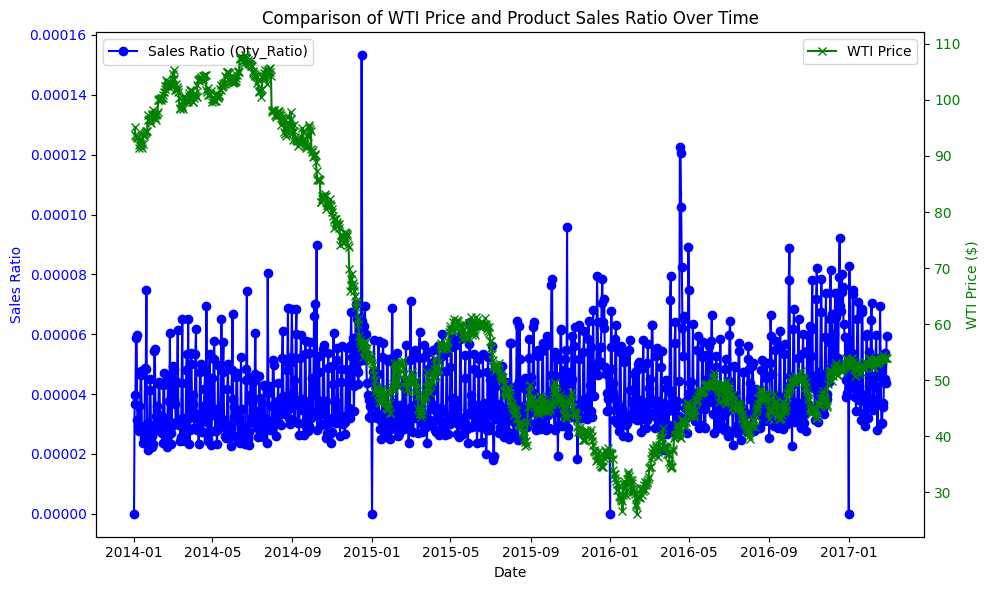

In [67]:
# 상품판매비율과 유가데이터(전체데이터)
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)].copy()

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 연도별 판매량 비율 계산
filtered_sales['Year'] = filtered_sales['Date'].dt.year
product_total_qty = df[df['Product_ID'] == product_id]['Qty'].sum()
filtered_sales['Qty_Ratio'] = filtered_sales['Qty'] / product_total_qty

# 날짜별로 데이터를 다시 설정하여 시각화 준비
filtered_sales = filtered_sales.groupby('Date').agg({'Qty_Ratio': 'sum', 'WTI_Price': 'mean'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매 비율 추이 그래프
ax1.plot(filtered_sales['Date'], filtered_sales['Qty_Ratio'], color='blue', label='Sales Ratio (Qty_Ratio)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 휘발유 가격 추이 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales['Date'], filtered_sales['WTI_Price'], color='green', label='WTI Price', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('Comparison of WTI Price and Product Sales Ratio Over Time')
fig.tight_layout()
plt.show()

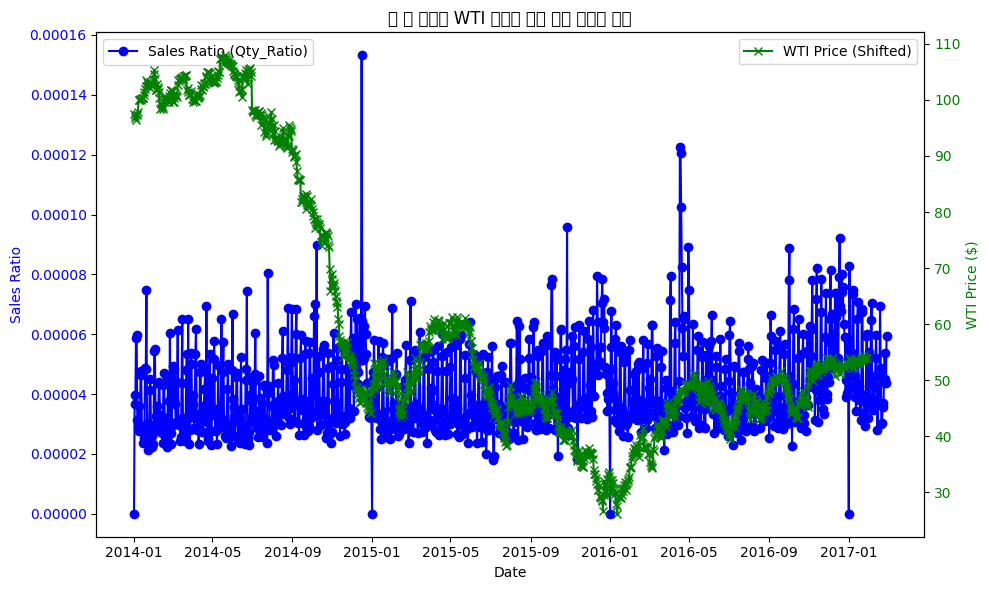

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# 특정 매장과 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)].copy()

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 연도별 판매량 비율 계산
product_total_qty = df[df['Product_ID'] == product_id]['Qty'].sum()
filtered_sales['Qty_Ratio'] = filtered_sales['Qty'] / product_total_qty

# Date를 인덱스로 설정하여 WTI_Price를 한 달 앞으로 이동
filtered_sales.set_index('Date', inplace=True)
filtered_sales['WTI_Price_Shifted'] = filtered_sales['WTI_Price'].shift(-30, freq='D')
filtered_sales.reset_index(inplace=True)  # Date를 다시 열로 복구

# 날짜별 집계된 데이터로 시각화 준비
filtered_sales = filtered_sales.groupby('Date').agg({'Qty_Ratio': 'sum', 'WTI_Price_Shifted': 'mean'}).reset_index()

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 판매 비율 그래프
ax1.plot(filtered_sales['Date'], filtered_sales['Qty_Ratio'], color='blue', label='Sales Ratio (Qty_Ratio)', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 한 달 이동한 유가 그래프 (이중 y축)
ax2 = ax1.twinx()
ax2.plot(filtered_sales['Date'], filtered_sales['WTI_Price_Shifted'], color='green', label='WTI Price (Shifted)', marker='x')
ax2.set_ylabel('WTI Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# 제목 및 레이아웃 설정
plt.title('한 달 이동된 WTI 가격과 상품 판매 비율의 비교')
fig.tight_layout()
plt.show()


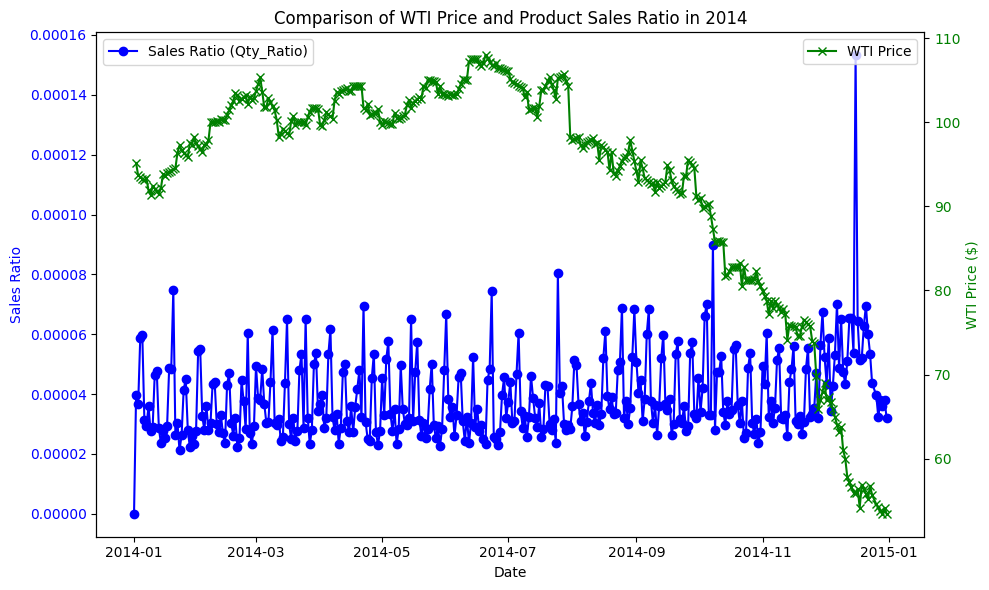

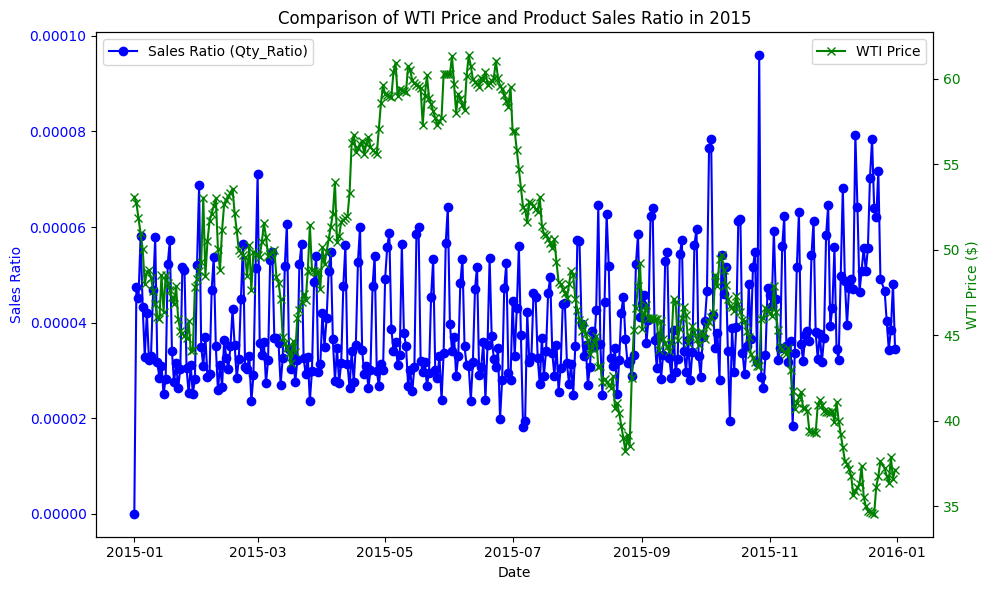

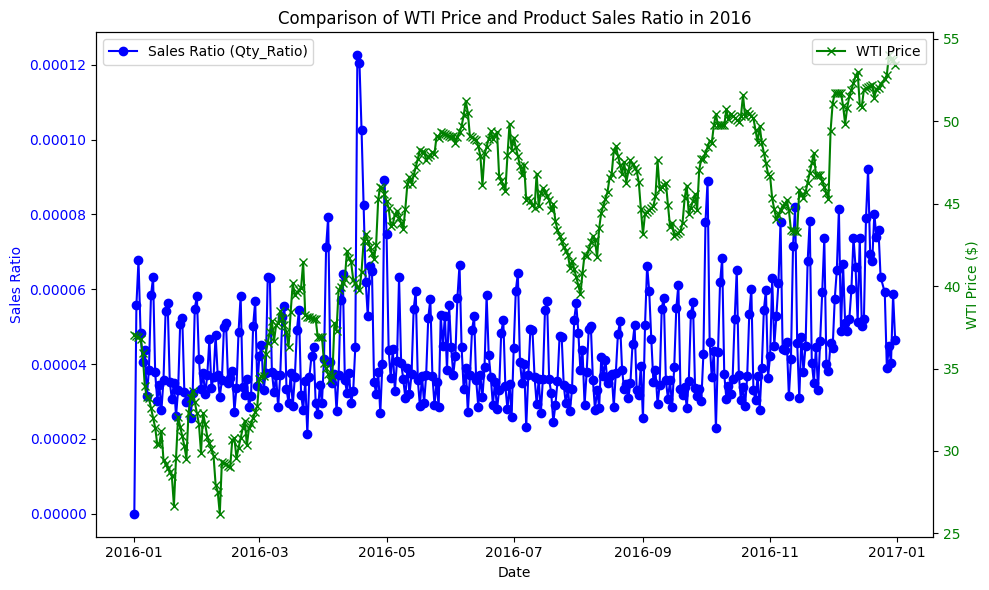

In [68]:
# 상품판매비율과 유가데이터(연도별)
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)].copy()

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 연도별 판매량 비율 계산
product_total_qty = df[df['Product_ID'] == product_id]['Qty'].sum()
filtered_sales['Qty_Ratio'] = filtered_sales['Qty'] / product_total_qty

# 연도별로 반복하여 시각화
for year in [2014, 2015, 2016]:
    # 해당 연도의 데이터만 필터링
    yearly_data = filtered_sales[filtered_sales['Date'].dt.year == year]

    # 날짜별로 집계
    yearly_data = yearly_data.groupby('Date').agg({'Qty_Ratio': 'sum', 'WTI_Price': 'mean'}).reset_index()

    # 시각화
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 판매 비율 추이 그래프
    ax1.plot(yearly_data['Date'], yearly_data['Qty_Ratio'], color='blue', label='Sales Ratio (Qty_Ratio)', marker='o')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales Ratio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # 휘발유 가격 추이 그래프 (이중 y축)
    ax2 = ax1.twinx()
    ax2.plot(yearly_data['Date'], yearly_data['WTI_Price'], color='green', label='WTI Price', marker='x')
    ax2.set_ylabel('WTI Price ($)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    # 제목 및 레이아웃 설정
    plt.title(f'Comparison of WTI Price and Product Sales Ratio in {year}')
    fig.tight_layout()
    plt.show()


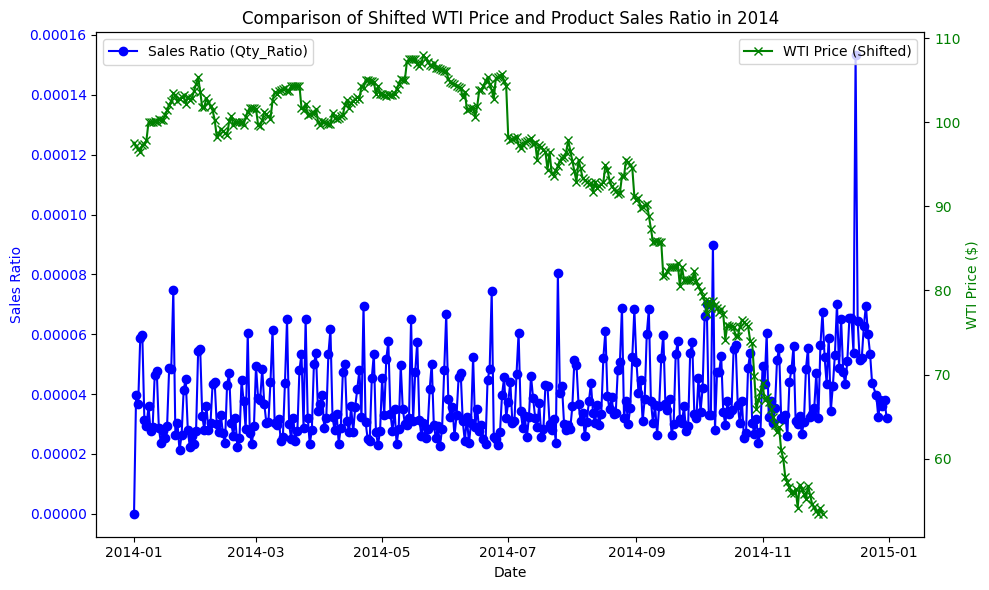

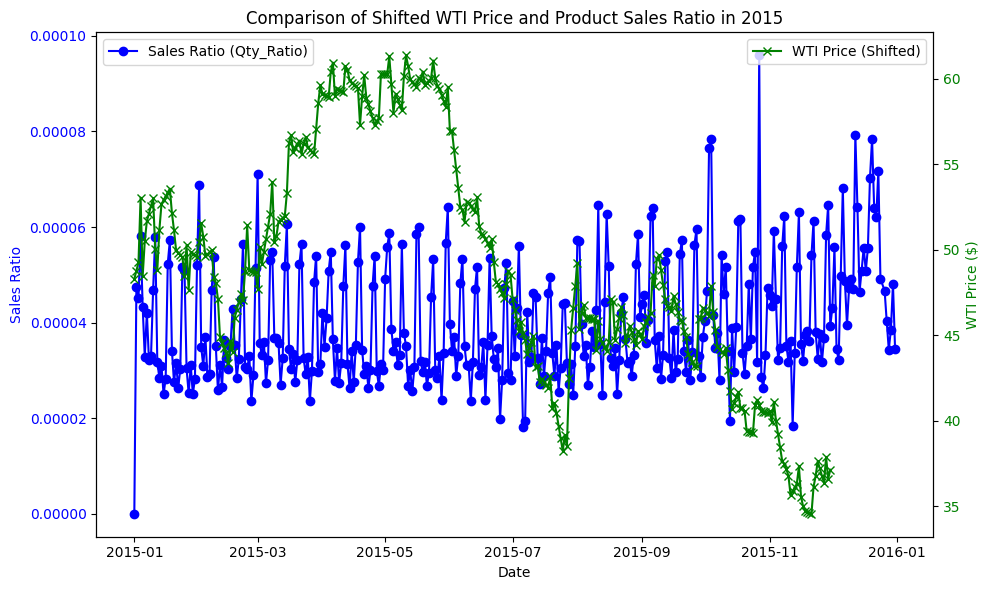

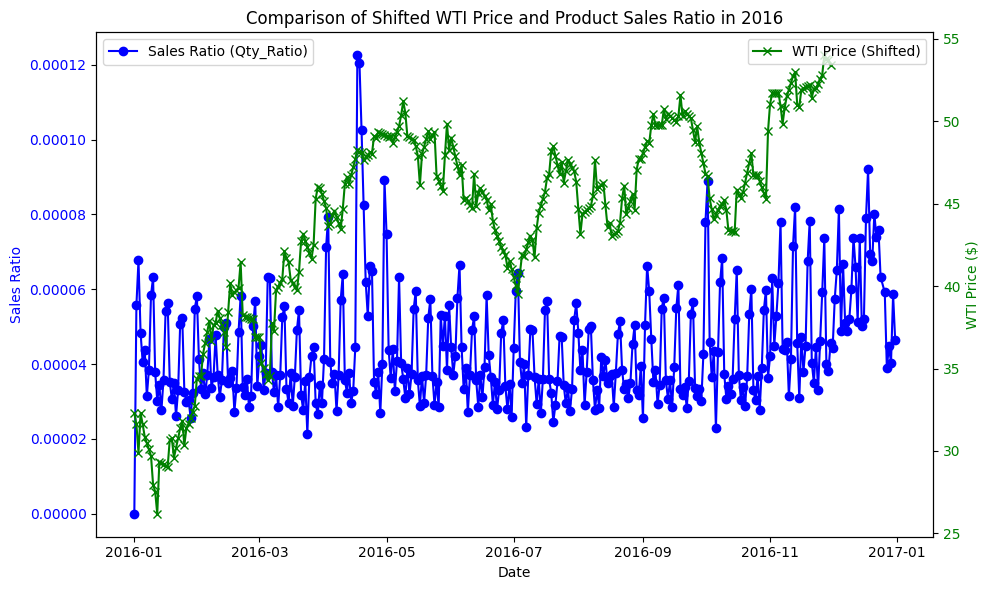

In [72]:
# 상품판매비율과 유가데이터(연도별)
# 대상 매장 및 상품 필터링
store_id = 44
product_id = 12
filtered_sales = df[(df['Store_ID'] == store_id) & (df['Product_ID'] == product_id)].copy()

# 휘발유 가격의 결측값을 선형 보간법으로 채우기
filtered_sales['WTI_Price'] = filtered_sales['WTI_Price'].interpolate(method='linear')

# 연도별 판매량 비율 계산
product_total_qty = df[df['Product_ID'] == product_id]['Qty'].sum()
filtered_sales['Qty_Ratio'] = filtered_sales['Qty'] / product_total_qty

# Date 열을 datetime 형식으로 변환
filtered_sales['Date'] = pd.to_datetime(filtered_sales['Date'])

# 연도별로 반복하여 시각화
for year in [2014, 2015, 2016]:
    # 해당 연도의 데이터만 필터링
    yearly_data = filtered_sales[filtered_sales['Date'].dt.year == year]

    # WTI_Price를 한 달 전으로 이동 (30일)
    yearly_data['WTI_Price_Shifted'] = yearly_data['WTI_Price'].shift(-30)

    # 날짜별로 집계
    yearly_data = yearly_data.groupby('Date').agg({'Qty_Ratio': 'sum', 'WTI_Price': 'mean', 'WTI_Price_Shifted': 'mean'}).reset_index()

    # 시각화
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 판매 비율 추이 그래프
    ax1.plot(yearly_data['Date'], yearly_data['Qty_Ratio'], color='blue', label='Sales Ratio (Qty_Ratio)', marker='o')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales Ratio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # 휘발유 가격 추이 그래프 (이중 y축)
    ax2 = ax1.twinx()
    ax2.plot(yearly_data['Date'], yearly_data['WTI_Price_Shifted'], color='green', label='WTI Price (Shifted)', marker='x')
    ax2.set_ylabel('WTI Price ($)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    # 제목 및 레이아웃 설정
    plt.title(f'Comparison of Shifted WTI Price and Product Sales Ratio in {year}')
    fig.tight_layout()
    plt.show()
